# O que fazer inicialmente?


* Obter um vídeo real com movimentação de pessoas;
* Processar com YOLOv8 + rastreador (DeepSORT);
* Extrair as posições de cada ID em cada frame;  
* Plotar essas posições como mapa de calor;
* Testar em outras situações.

In [ ]:
# Instalando as bibliotecas/dependências necessárias:

!pip install ultralytics deep_sort_realtime opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
   

In [ ]:
# Upload do vídeo
from google.colab import files
uploaded = files.upload()

# Assumimos que só há um arquivo enviado e pegamos o nome:
video_path = list(uploaded.keys())[0]
print("Vídeo carregado:", video_path)



0: 384x640 19 persons, 1 umbrella, 11.0ms
Speed: 2.3ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 1 umbrella, 7.3ms
Speed: 3.1ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 umbrella, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 umbrella, 11.1ms
Speed: 3.5ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 umbrella, 7.5ms
Speed: 4.0ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 umbrella, 7.8ms
Speed: 3.6ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 2 horses, 1 umbrella, 8.3ms
Speed: 3.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 perso

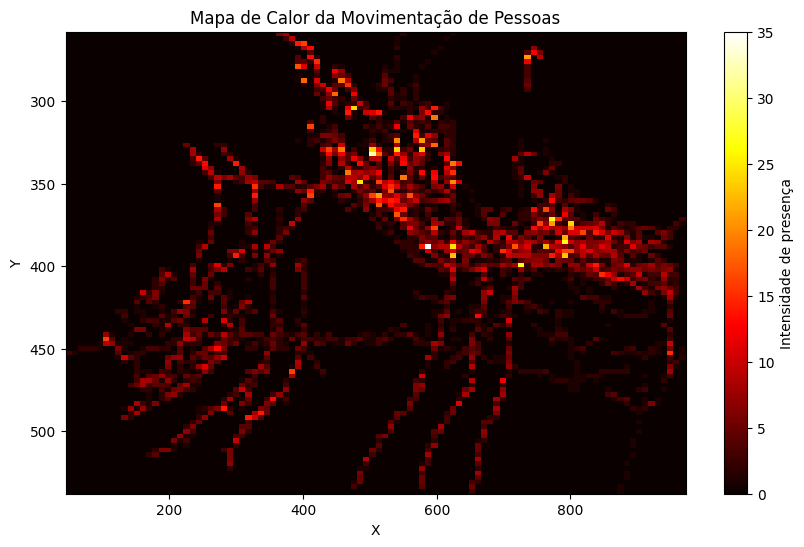

In [ ]:
# Testando:

import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import matplotlib.pyplot as plt

# --- 1. Carregar o modelo YOLOv8 pré-treinado ---
model = YOLO("yolov8n.pt")  # "n" = nano, é leve

# --- 2. Iniciar o DeepSORT para rastrear pessoas ---
tracker = DeepSort(max_age=15)

# --- 3. Carregar o vídeo ---
video_path = "/content/MOT20-01-raw.webm"  # Caminho do vídeo
cap = cv2.VideoCapture(video_path)

# Listas para armazenar posições rastreadas
all_x = []
all_y = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # --- 4. Rodar YOLOv8 para detectar pessoas ---
    results = model(frame)[0]
    detections = []

    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, conf, cls = result
        if int(cls) == 0:  # classe 0 = pessoa
            detections.append(([x1, y1, x2 - x1, y2 - y1], conf, 'person'))

    # --- 5. Atualizar o rastreador com as detecções ---
    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        ltrb = track.to_ltrb()  # left, top, right, bottom
        x1, y1, x2, y2 = ltrb
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)

        all_x.append(cx)
        all_y.append(cy)

cap.release()

# --- 6. Criar o mapa de calor com os pontos acumulados ---
plt.figure(figsize=(10, 6))
plt.hist2d(all_x, all_y, bins=100, cmap='hot')
plt.colorbar(label="Intensidade de presença")
plt.gca().invert_yaxis()  # Inverter eixo Y para coincidir com imagem
plt.title("Mapa de Calor da Movimentação de Pessoas")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
